### Variational Classifier  example 3  : random 2D circle --> binary class

INPUT: 2 real-valued vectors, works with shot-based simulator
Based on https://pennylane.ai/qml/demos/tutorial_variational_classifier/

In [150]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import matplotlib.pyplot as plt
qcstyle="black_white"

In [151]:
n_qubits=3
# pick one device
if 0:     # Initialize the FakeHanoi simulator
    from qiskit.providers.aer import AerSimulator
    from qiskit.providers.fake_provider  import FakeHanoi
    fake_hanoi_backend = FakeHanoi()
    aer_simulator = AerSimulator.from_backend(fake_hanoi_backend)
    dev = qml.device('qiskit.aer', wires=n_qubits, backend=aer_simulator, shots=shots)
if 0:  # Set up the state vector sim  device
    dev = qml.device('default.qubit', wires=n_qubits)
if 1: # Set up a shot-based sim device.
    dev = qml.device('default.qubit', wires=n_qubits, shots=shots)

### input data generated previously are imported

In [152]:
print('input 2D circle binary data and pre-process') 
XY = np.load("../notebooks/data/circ2d_bin.npy")
# Separate the data and labels
X = XY[:,:-1]
Y = XY[:,-1]
print('X sh:', X.shape, Y.shape)

print(f"First X sample (original)  : {X[0]}, shape:",X.shape)

print('Labels sample',Y[::10])
print(' Warning: data were not shuffled yet')

# Split data on train/test subsets
np.random.seed(0)
num_data = Y.shape[0]
num_train = int(0.8 * num_data)
index = np.random.permutation(range(num_data))
X_train = X[index[:num_train]]
Y_train = Y[index[:num_train]]
X_val = X[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

print('train labels sample',Y_train[:10])
print('train X sample',X_train[:3])
print('val labels sample',Y_val)

input 2D circle binary data and pre-process
X sh: (300, 2) (300,)
First X sample (original)  : [-0.63598068  0.41293217], shape: (300, 2)
Labels sample [ 1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1.  1. -1. -1. -1.
  1.  1.  1.  1. -1. -1.  1.  1. -1. -1. -1. -1.]
train labels sample [-1. -1. -1.  1.  1. -1. -1. -1.  1.  1.]
train X sample [[-0.72389289 -0.77640799]
 [-0.8875075  -0.66475994]
 [ 0.53171998  0.76290153]]
val labels sample [ 1.  1. -1. -1. -1.  1.  1. -1. -1.  1. -1. -1. -1.  1. -1. -1. -1. -1.
 -1.  1. -1. -1.  1. -1.  1.  1.  1.  1. -1. -1.  1. -1.  1. -1.  1.  1.
  1.  1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1.
 -1.  1. -1. -1. -1. -1.]


[Text(0.5, 1.0, 'Original data 2 classes')]

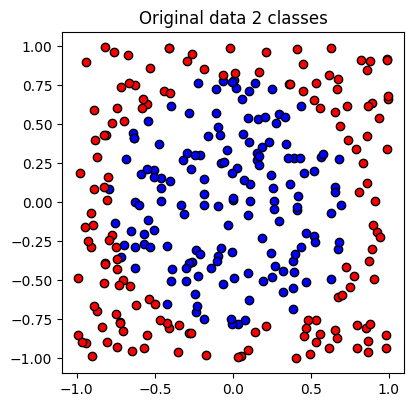

In [153]:
nrow,ncol=1,3
fig=plt.figure(facecolor='white', figsize=(15,4.5))

ax = plt.subplot(nrow,ncol,1) ; ax.set_aspect(1.)
ax.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
ax.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
ax.set(title="Original data 2 classes")

### Encoding
Input X is in range [-1,1], it will be mapped to theta=acos(X) and encoded as RY(tehta) onto 2 qubits

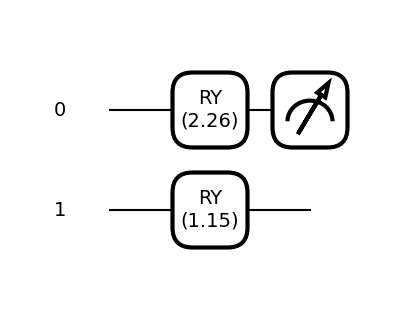

In [154]:
def state_preparation(x):
    a=np.arccos(x)
    qml.RY(a[0], wires=0)
    qml.RY(a[1], wires=1)

@qml.qnode(dev)
def test(angles):
    state_preparation(angles)
    return qml.expval(qml.PauliZ(0))

qml.draw_mpl(test, decimals=2, style=qcstyle)(X[0]); plt.show()
#print(qml.draw(test, decimals=2)(X[0]), '\n')

### Define QML layers, as   2-qubit variational layer

define the variational quantum circuit as this state preparation routine, followed by a repetition of the layer structure.

QML dims  qubits=3  EfficientSU2 ansatz, layers=2
weights sh: (2, 5) 
 full circ:


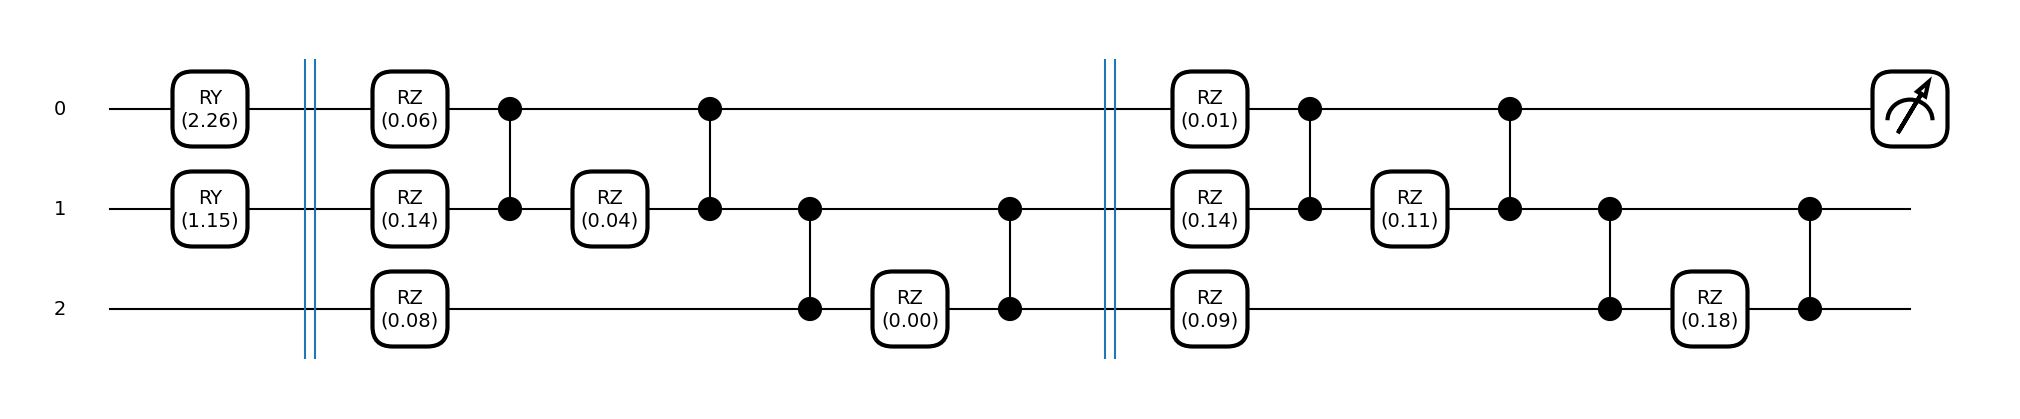

In [155]:
def parametrized_cz_ansatz(params):
    """
    An ansatz using parameterized CZ gates for a 3-qubit system.
    
    params should be an array of shape (layers, n_qubits + n_qubits - 1),
    where the first n_qubits parameters in each layer are for single-qubit
    rotations, and the following n_qubits - 1 parameters are for the 
    parameterized CZ interactions between adjacent qubits.
    """
    layers = params.shape[0]
    
    for layer in range(layers):
        qml.Barrier()
        # Apply single-qubit rotations
        for qubit in range(n_qubits):
            qml.RZ(params[layer, qubit], wires=qubit)
        
        # Apply parameterized CZ gates between adjacent qubits
        for qubit in range(n_qubits - 1):
            # Simulate a parameterized CZ by a RZ rotation between CZ gates
            qml.CZ(wires=[qubit, qubit + 1])
            qml.RZ(params[layer, n_qubits + qubit], wires=qubit + 1)
            qml.CZ(wires=[qubit, qubit + 1])

@qml.qnode(dev)
def circuit(params,x):
    state_preparation(x)  
    parametrized_cz_ansatz(params)
    return qml.expval(qml.PauliZ(0))


# Example usage
layers = 2
weights_init = 0.2 * np.random.random(size=(layers, n_qubits + n_qubits - 1))

print('QML dims  qubits=%d  EfficientSU2 ansatz, layers=%d'%(n_qubits,layers))
print('weights sh:',weights_init.shape,'\n full circ:')

qml.draw_mpl(circuit, decimals=2, style=qcstyle)(weights_init,X[0]); plt.show()
#print(qml.draw(circuit, decimals=2)(weights_init,X[0]), '\n')

### remaining classical functionality required for ML training 

In [156]:
#  loss-function
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def cost(weights,  X, Y):
    global function_calls
    function_calls += X.shape[0]
    # Transpose the batch of input data in order to match the expected dims
    pred = circuit(weights,  X.T) # circuit is vectorized
    return square_loss(Y, pred)
    
#  ACCURACY, for monitoring only
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    #print('AAA',acc,len(labels),'\nlab:',labels,'\npred:', predictions)
    #print('DIF',labels-predictions)
    return acc

In [157]:
print('\n train the variational classifier...')
shots=5000
steps = 100*3
batch_size = 10
weights = weights_init

if 1:  # initial accuracy
    pred_val = np.sign(circuit(weights,  X_val.T))
    acc_val = accuracy(Y_val, pred_val)

function_calls = 0
for it in range(steps):
    # Update the weights by one optimizer step, use just one batch-size of data selected at random, so 1 step is NOT 1 epoch
    batch_index = np.random.randint(0, num_train, (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]
    
    weights = opt.step(lambda p: cost(p, X_batch, Y_batch), weights)
    # Compute predictions on train and validation set
    pred_val = np.sign(circuit(weights,  X_val.T))
    acc_val = accuracy(Y_val, pred_val)
    pred_train = np.sign(circuit(weights,  X_train.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, pred_train)

    if (it + 1) % 10 == 0:
        _cost = cost(weights,  X_train,Y_train)
        print(
            f"Iter: {it + 1:5d} | train Cost: {_cost:0.4f} | "
            f"Acc train: {acc_train:0.4f} | Acc validation: {acc_val:0.4f}"
        )

    if it==0:
        print('X_batch sh:',X_batch.shape)
        print('pred_train sh:',pred_train.shape,' pred_val sh:',pred_val.shape,' acc_train sh:', acc_train.shape)



 train the variational classifier...
X_batch sh: (10, 2)
pred_train sh: (240,)  pred_val sh: (60,)  acc_train sh: ()
Iter:    10 | train Cost: 1.3310 | Acc train: 0.5083 | Acc validation: 0.5333
Iter:    20 | train Cost: 1.3305 | Acc train: 0.5083 | Acc validation: 0.5167
Iter:    30 | train Cost: 1.3309 | Acc train: 0.5083 | Acc validation: 0.5000
Iter:    40 | train Cost: 1.3322 | Acc train: 0.5125 | Acc validation: 0.5167
Iter:    50 | train Cost: 1.3317 | Acc train: 0.5167 | Acc validation: 0.5000
Iter:    60 | train Cost: 1.3330 | Acc train: 0.5083 | Acc validation: 0.5167
Iter:    70 | train Cost: 1.3337 | Acc train: 0.5000 | Acc validation: 0.5167
Iter:    80 | train Cost: 1.3301 | Acc train: 0.5042 | Acc validation: 0.5000
Iter:    90 | train Cost: 1.3329 | Acc train: 0.5042 | Acc validation: 0.5167
Iter:   100 | train Cost: 1.3346 | Acc train: 0.5125 | Acc validation: 0.5333
Iter:   110 | train Cost: 1.3312 | Acc train: 0.5042 | Acc validation: 0.5167
Iter:   120 | train Cost

In [158]:
print('\n INFER on val-data')
#  define a function to make a predictions over multiple data points.

pred_val = np.sign(circuit(weights,  X_val.T))
acc_val = accuracy(Y_val, pred_val)
print('\npred_val:%s  acc_val=%.3f'%(pred_val,acc_val))
print('targets:',Y_val,type(Y_val))
res=preds_val - Y_val
print('L2:',res**2)
loss = square_loss(Y_val, pred_val)
print('loss:',loss,'ndata:',pred_val.shape)

print('end-weight:',weights)
print("Total number of cost function calls:", function_calls)
print('qml setup:',dev,opt)


 INFER on val-data

pred_val:[ 1.  1.  1. -1.  1. -1. -1. -1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1.
  1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1. -1. -1. -1. -1.  1. -1. -1.
  1.  1. -1. -1. -1.  1. -1.  1. -1.  1.  1. -1.  1.  1. -1.  1. -1.  1.
 -1. -1. -1. -1. -1.  1.]  acc_val=0.517
targets: [ 1.  1. -1. -1. -1.  1.  1. -1. -1.  1. -1. -1. -1.  1. -1. -1. -1. -1.
 -1.  1. -1. -1.  1. -1.  1.  1.  1.  1. -1. -1.  1. -1.  1. -1.  1.  1.
  1.  1. -1.  1.  1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1.
 -1.  1. -1. -1. -1. -1.] <class 'pennylane.numpy.tensor.tensor'>
L2: [4. 0. 0. 4. 0. 0. 4. 4. 4. 0. 4. 0. 0. 4. 4. 0. 4. 0. 0. 0. 0. 4. 0. 0.
 4. 4. 4. 4. 4. 4. 0. 0. 0. 0. 4. 0. 0. 0. 4. 0. 4. 4. 0. 4. 4. 4. 4. 0.
 0. 0. 0. 0. 4. 0. 4. 0. 4. 4. 4. 4.]
loss: 1.9333333333333333 ndata: (60,)
end-weight: [[0.06585637 0.14145828 0.07506274 0.03637503 0.0038219 ]
 [0.01676367 0.13662856 0.09260381 0.10553463 0.17990956]]
Total number of cost function calls: 13200
qml setup: <defaul

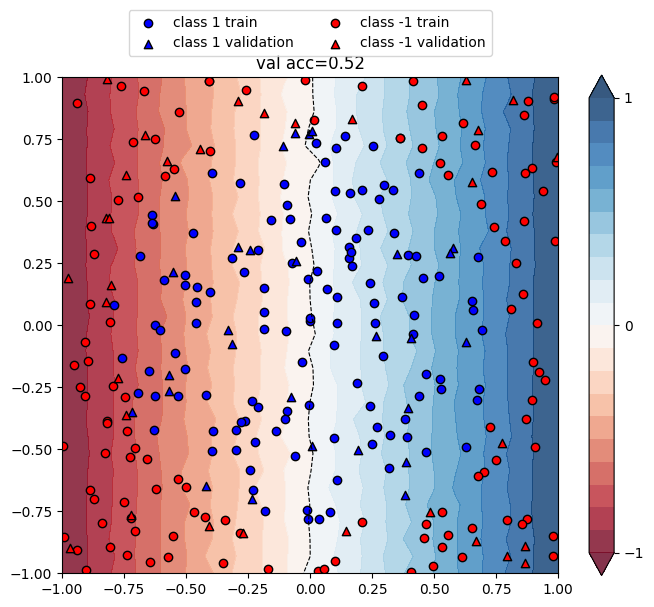

In [159]:
# We can plot the continuous output of the variational classifier for the first two dimensions of the Iris data set.
fig=plt.figure(facecolor='white', figsize=(8,6.5))
nrow,ncol=1,1
cm = plt.cm.RdBu
ax = plt.subplot(nrow,ncol,1) ; ax.set_aspect(1.)

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(-1,1, 30), np.linspace(-1,1, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

features_grid = np.array([x for x in X_grid])  # angles are new features
predictions_grid = circuit(weights,  features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
ax.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    ax.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    ax.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
ax.set(title='val acc=%.2f'%acc_val)
plt.show()